1. **Import packages**

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib as mp
import statsmodels.api as sm
import pmdarima as pm
import time
from datetime import datetime, timedelta
from scipy import stats
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb        #JZ
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

2. **Load data into pandas dataframe**

In [3]:
masterdf=pd.read_csv('data//CMaster2_HPS_CDC_CPS_Vaccinated_with_lock.csv')

In [4]:
masterdf.info()
masterdf.head()
#masterdf['MONTH'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131705 entries, 0 to 3131704
Data columns (total 27 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   field1                               int64  
 1   YMFIPS                               object 
 2   YEAR                                 int64  
 3   MONTH                                object 
 4   FIPS                                 int64  
 5   STATE_C                              object 
 6   LOCATION                             object 
 7   TBIRTH_YEAR                          int64  
 8   EEDUC                                int64  
 9   THHLD_NUMPER                         int64  
 10  THHLD_NUMKID                         int64  
 11  THHLD_NUMADLT                        int64  
 12  WRKLOSS                              int64  
 13  KINDWORK                             int64  
 14  ANXIOUS                              int64  
 15  WORRY                           

,field1,YMFIPS,YEAR,MONTH,FIPS,STATE_C,LOCATION,TBIRTH_YEAR,EEDUC,THHLD_NUMPER,...,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,lockdown
0,0,2021-9-01,2021,SEP,1,AL,Alabama,1941,7,1,...,-88,-88,4,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
1,1,2021-9-01,2021,SEP,1,AL,Alabama,1973,4,3,...,1,4,6,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
2,2,2021-9-13,2021,SEP,13,GA,Georgia,1970,4,1,...,1,3,1,0.043,58816.0,5828605.0,54.90,4823331.0,45.43,0
3,3,2021-9-01,2021,SEP,1,AL,Alabama,1969,3,6,...,-88,-88,-88,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
4,4,2021-9-01,2021,SEP,1,AL,Alabama,1977,4,3,...,-88,-88,-88,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0


3. **Clean data**

* Convert year month fips field to datetime datatype

In [5]:
m_n={'JAN':1, 'FEB':2, 'MAR':3, 'APR':4,'MAY':5,'JUN':6, 'JUL':7, 'AUG':8,'SEP':9, 'OCT':10,'NOV':11, 'DEC':12}
masterdf['MONTH'] = masterdf['MONTH'].apply(lambda i: m_n[i])
masterdf['YEARMONTH']=pd.to_datetime(masterdf['YEAR'].astype('str')+'-'+masterdf['MONTH'].astype('str')+'-01')
#print(masterdf.iloc[1])
masterdf.info()
#print(masterdf['YEARMONTH'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131705 entries, 0 to 3131704
Data columns (total 28 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   field1                               int64         
 1   YMFIPS                               object        
 2   YEAR                                 int64         
 3   MONTH                                int64         
 4   FIPS                                 int64         
 5   STATE_C                              object        
 6   LOCATION                             object        
 7   TBIRTH_YEAR                          int64         
 8   EEDUC                                int64         
 9   THHLD_NUMPER                         int64         
 10  THHLD_NUMKID                         int64         
 11  THHLD_NUMADLT                        int64         
 12  WRKLOSS                              int64         
 13  KINDWORK                   

* Understand how many records in work loss data element are null. Result is very few, so will just remove record with null wrkloss

In [6]:
masterdf['WRKLOSS'].value_counts()

 2     2102136
 1     1002257
-99      19450
-88       7862
Name: WRKLOSS, dtype: int64

* Given result, we should remove the records with -99/-88 values in WRKLOSS, ANXIOUS, WORRY, DOWN, INCOME

In [7]:
masterdf=masterdf[(masterdf['WRKLOSS'] != -99) & (masterdf['WRKLOSS'] !=-88) &
                  (masterdf['ANXIOUS'] != -99) & (masterdf['ANXIOUS'] !=-88) &
                  (masterdf['WORRY'] != -99) & (masterdf['WORRY'] !=-88) &
                  (masterdf['DOWN'] != -99) & (masterdf['DOWN'] !=-88) &
                  (masterdf['INCOME'] != -99) & (masterdf['INCOME'] !=-88)].reset_index(drop=True)

* Rename some fields, and drop some not needed for modeling

In [8]:
"""def awd_classify(awdnum:int=6)-> int :
    if awdnum <=4:
        awdclass=1
    elif awdnum <=7:
        awdclass=2
    elif awdnum <=10:
        awdclass=3
    else:
        awdclass=4
        
    return(awdclass)
"""

def awd_classify(awdnum:int=6)-> int :
    if awdnum <=7:
        awdclass=0
    else:
        awdclass=1       
    return(awdclass)


#masterdf=masterdf.rename(columns={"people_vaccinated": "VAXXED", "people_fully_vaccinated": "FULLYVAXXED"})

masterdf['ANXWORRYDWN_NUM']=masterdf.ANXIOUS+masterdf.WORRY+masterdf.DOWN
#masterdf['ANXWORRYDWN']=masterdf.apply(lambda row: awd_classify(row['ANXIOUS']+row['WORRY']+row['DOWN']), axis=1)
masterdf['ANXWORRYDWN']=np.where(masterdf['ANXWORRYDWN_NUM']>7, 1, 0)

masterdf=masterdf[['YEARMONTH','STATE_C','TBIRTH_YEAR','EEDUC','WRKLOSS','KINDWORK',
                   'MORTLMTH','MORTCONF','INCOME', 'REMPCT', 'CDCCOUNT', 
                   'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred',
                   'ANXWORRYDWN_NUM','ANXWORRYDWN']].reset_index(drop=True)
                
#masterdf=masterdf.drop(columns=['YMFIPS','YEAR','MONTH','FIPS','STATE','LOCATION','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred'])

In [9]:
print(masterdf.info())
print(masterdf['ANXWORRYDWN'].value_counts())
masterdf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502286 entries, 0 to 2502285
Data columns (total 15 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   YEARMONTH                            datetime64[ns]
 1   STATE_C                              object        
 2   TBIRTH_YEAR                          int64         
 3   EEDUC                                int64         
 4   WRKLOSS                              int64         
 5   KINDWORK                             int64         
 6   MORTLMTH                             int64         
 7   MORTCONF                             int64         
 8   INCOME                               int64         
 9   REMPCT                               float64       
 10  CDCCOUNT                             float64       
 11  people_vaccinated_per_hundred        float64       
 12  people_fully_vaccinated_per_hundred  float64       
 13  ANXWORRYDWN_NUM            

,YEARMONTH,STATE_C,TBIRTH_YEAR,EEDUC,WRKLOSS,KINDWORK,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ANXWORRYDWN_NUM,ANXWORRYDWN
0,2021-09-01,AL,1941,7,2,-88,-88,-88,4,0.032,44878.0,52.69,42.62,3,0
1,2021-09-01,AL,1973,4,2,5,1,4,6,0.032,44878.0,52.69,42.62,6,0
2,2021-09-01,GA,1970,4,1,-88,1,3,1,0.043,58816.0,54.90,45.43,5,0
3,2021-09-01,AK,1965,4,2,3,-88,-88,7,0.048,7180.0,57.28,50.59,6,0
4,2021-09-01,AK,1983,7,2,1,-88,4,6,0.048,7180.0,57.28,50.59,3,0


* Profile several fields

In [10]:
print('MORTLMTH values:', masterdf[(masterdf['MORTLMTH']!=-99) & (masterdf['MORTLMTH']!=-88)].shape[0])
print('MORTCONF values:', masterdf[(masterdf['MORTCONF']!=-99) & (masterdf['MORTCONF']!=-88)].shape[0])
print('KINDWORK values:', masterdf[(masterdf['KINDWORK']!=-99) & (masterdf['KINDWORK']!=-88)].shape[0])

masterdf=masterdf[(masterdf['MORTLMTH'] != -99) & (masterdf['MORTLMTH'] !=-88) &
                  (masterdf['MORTCONF'] != -99) & (masterdf['MORTCONF'] !=-88) &
                  (masterdf['KINDWORK'] != -99) & (masterdf['KINDWORK'] !=-88)].reset_index(drop=True)

# find total number of record with null vaxx values
print(masterdf['people_vaccinated_per_hundred'].isna().sum())
print(masterdf['people_fully_vaccinated_per_hundred'].isna().sum())
# backfill null vaxx values with 0
masterdf=masterdf.fillna(0).reset_index(drop=True)

#profile mental state values
print(masterdf['ANXWORRYDWN'].value_counts())

print(masterdf.info())

MORTLMTH values: 1472272
MORTCONF values: 1829379
KINDWORK values: 1464252
649519
649519
0    759582
1    201140
Name: ANXWORRYDWN, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   YEARMONTH                            960722 non-null  datetime64[ns]
 1   STATE_C                              960722 non-null  object        
 2   TBIRTH_YEAR                          960722 non-null  int64         
 3   EEDUC                                960722 non-null  int64         
 4   WRKLOSS                              960722 non-null  int64         
 5   KINDWORK                             960722 non-null  int64         
 6   MORTLMTH                             960722 non-null  int64         
 7   MORTCONF                             960722 non-null  int64         
 8  

* further edit the  MORTLMTH MORTCONF and KINDWORK data

In [11]:
print(masterdf['MORTLMTH'].value_counts())
print(masterdf['MORTCONF'].value_counts())
print(masterdf['KINDWORK'].value_counts())
print(masterdf['YEARMONTH'].value_counts())

1    893718
2     55842
3     11162
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     23370
5     13300
Name: MORTCONF, dtype: int64
2    529748
1    176385
3    130348
4    106208
5     18033
Name: KINDWORK, dtype: int64
2020-05-01    153293
2020-06-01    148335
2020-07-01    109646
2020-09-01     82134
2021-09-01     46280
2020-10-01     39595
2021-02-01     37983
2021-03-01     37920
2020-11-01     37721
2021-01-01     37122
2021-04-01     35515
2021-08-01     35402
2021-05-01     34454
2020-04-01     31180
2021-06-01     31155
2020-08-01     28717
2020-12-01     17922
2021-07-01     16348
Name: YEARMONTH, dtype: int64


* convert MORTLMTH with values 2 and 3 to 0
* convert MORTCONF with values 5 to 1
* convert KINDWORK to categorical var

In [12]:
#replace values 2 and 3 with 0 (did not pay), existing 1 means paid
masterdf.loc[(masterdf['MORTLMTH'] == 2) | (masterdf['MORTLMTH'] == 3),'MORTLMTH']=0
print(masterdf['MORTLMTH'].value_counts())

#replace values 5 with 1 (did not pay)
masterdf.loc[(masterdf['MORTCONF'] == 5),'MORTCONF']=1
print(masterdf['MORTCONF'].value_counts())

#categorize/onehot the kind of work variable
KINDWORK_onehot = pd.get_dummies(masterdf['KINDWORK'])  
KINDWORK_onehot.rename(columns={1:'Work_Government',2:'Work_Private',3:'Work_NonProfit',4:'Work_SelfEmp',5:'Work_FamilyBiz'},inplace=True)
masterdf = pd.concat([masterdf,KINDWORK_onehot],axis=1)
print(masterdf.info())

1    893718
0     67004
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     36670
Name: MORTCONF, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   YEARMONTH                            960722 non-null  datetime64[ns]
 1   STATE_C                              960722 non-null  object        
 2   TBIRTH_YEAR                          960722 non-null  int64         
 3   EEDUC                                960722 non-null  int64         
 4   WRKLOSS                              960722 non-null  int64         
 5   KINDWORK                             960722 non-null  int64         
 6   MORTLMTH                             960722 non-null  int64         
 7   MORTCONF                             960722 non-null  int64         
 8   INCOME        

* ***Create two dataset, one for the individual level modeling and one for the statewide level***

In [13]:
# drop columns not need for modeling
masterdf.drop(columns=['KINDWORK'],inplace=True)

############################################################################################
# aggregate at the state/month level, then perform the aggregated data set modeling later on
############################################################################################
masterdfagg=masterdf.groupby(['YEARMONTH','STATE_C']).mean()
#print(masterdfagg.info())


#######################################################################
# main dataset for performing modeling at the individual survey level
#######################################################################
masterdf.drop(columns=['STATE_C','ANXWORRYDWN_NUM', 'YEARMONTH'],inplace=True)
#masterdf.info()

* Look at variance inflation factor

In [19]:
x_sample=masterdf.sample(frac=0.00005, replace=False, random_state=1)

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['ANXWORRYDWN'])]]
print(calc_vif(X))

#X = masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['people_vaccinated_per_hundred','ANXWORRYDWN','Work_Private'])]]
#calc_vif(X)

                              variables           VIF
0                           TBIRTH_YEAR      1.037048
1                                 EEDUC      1.263738
2                               WRKLOSS      1.164638
3                              MORTLMTH      1.346663
4                              MORTCONF      1.503860
5                                INCOME      1.317906
6                                REMPCT      1.204436
7                              CDCCOUNT      1.014591
8         people_vaccinated_per_hundred     31.281098
9   people_fully_vaccinated_per_hundred     31.332042
10                      Work_Government   4947.603876
11                         Work_Private  14875.101144
12                       Work_NonProfit   3656.728662
13                         Work_SelfEmp   2963.666175
14                       Work_FamilyBiz    506.359623


* Run pairwise scatter plot

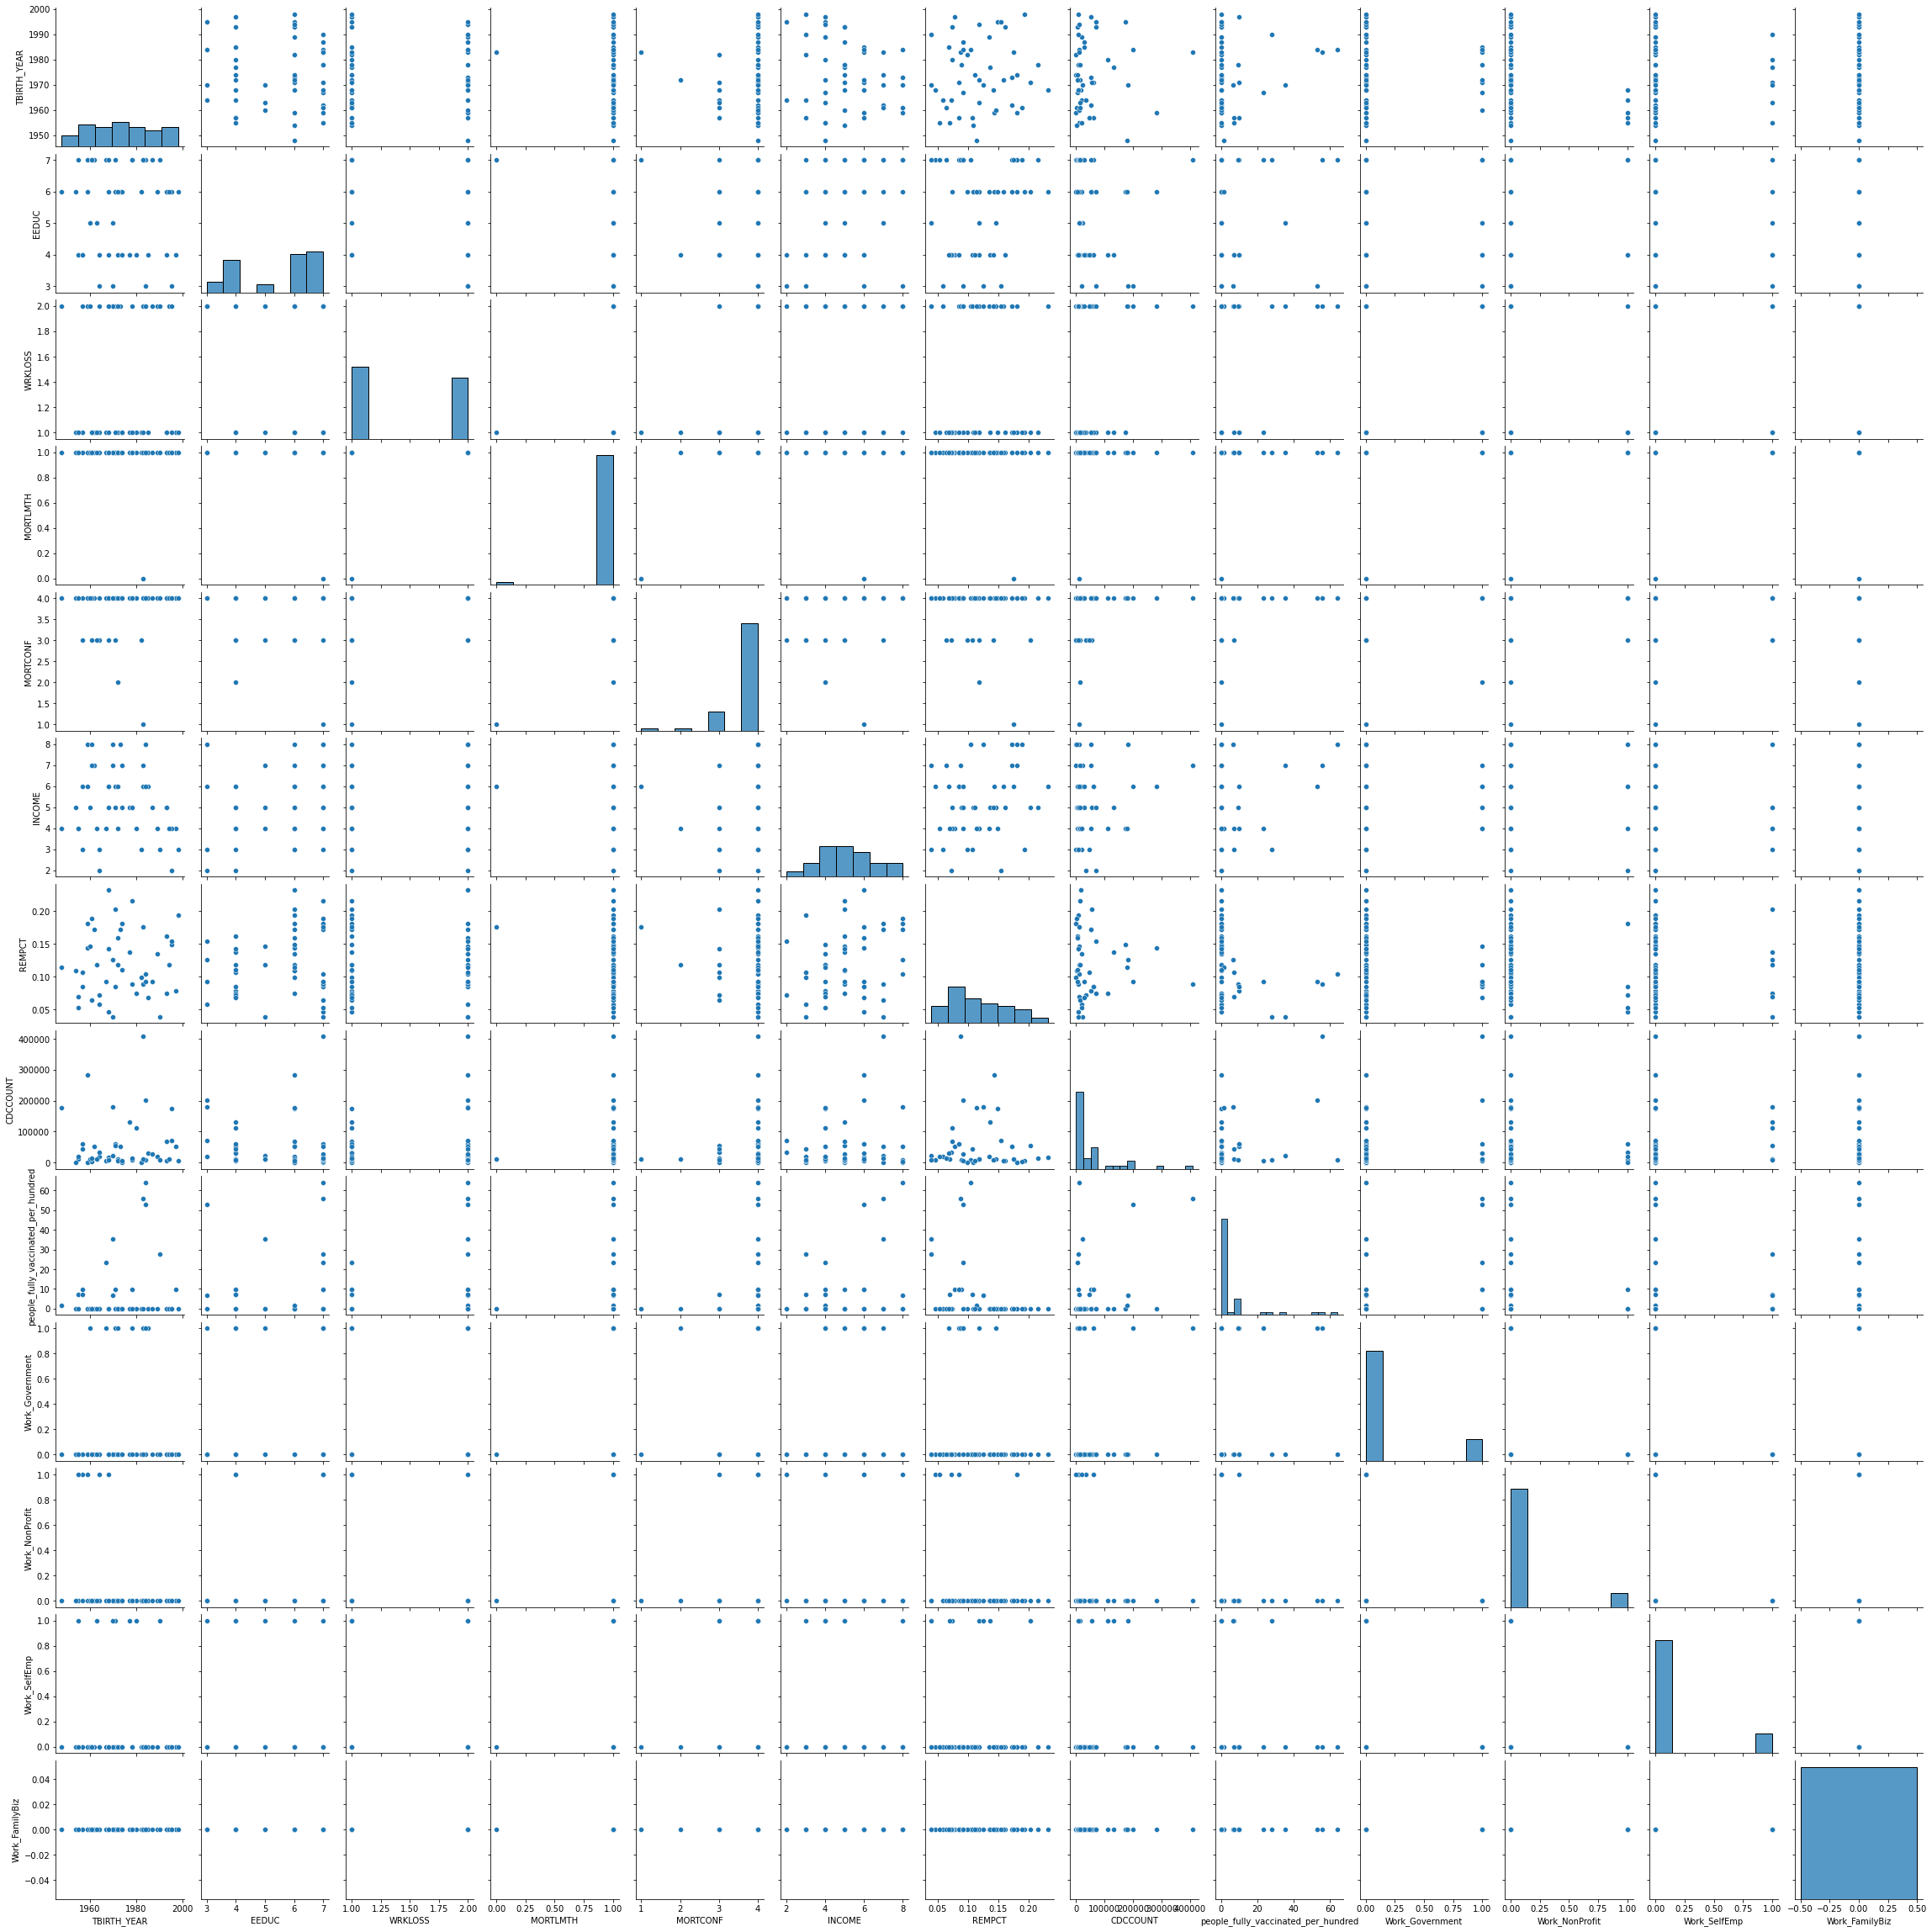

In [18]:
x_sample=masterdf.sample(frac=0.00005, replace=False, random_state=1)

sns.pairplot(x_sample.loc[:,~x_sample.columns.isin(['people_vaccinated_per_hundred','ANXWORRYDWN','Work_Private'])])

* Run tukeyHSD

* look at correlation

In [20]:
mdfcorr=masterdf.loc[:, masterdf.columns != 'ANXWORRYDWN'].corr()

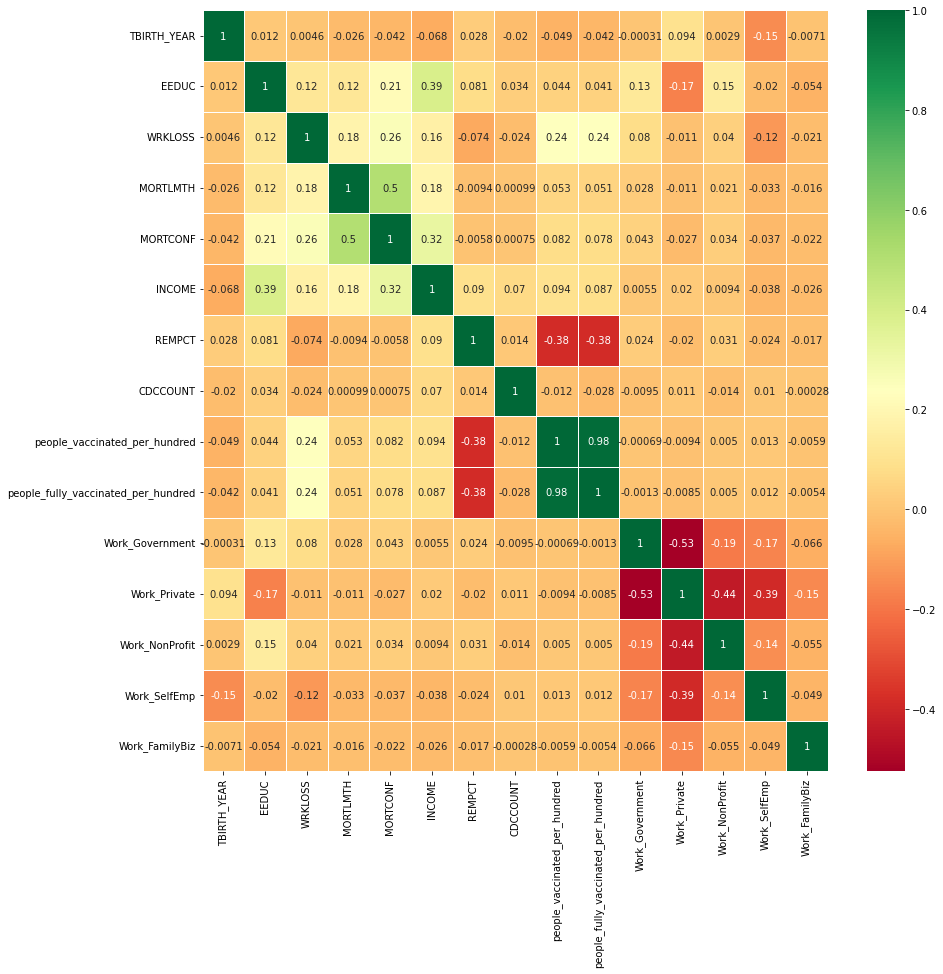

In [21]:
# heatmap plot
plt.figure(figsize=(14,14))
sns.heatmap(mdfcorr,cbar=True,linewidths=.5,yticklabels=True,xticklabels=True,annot=True,cmap="RdYlGn")
plt.show()

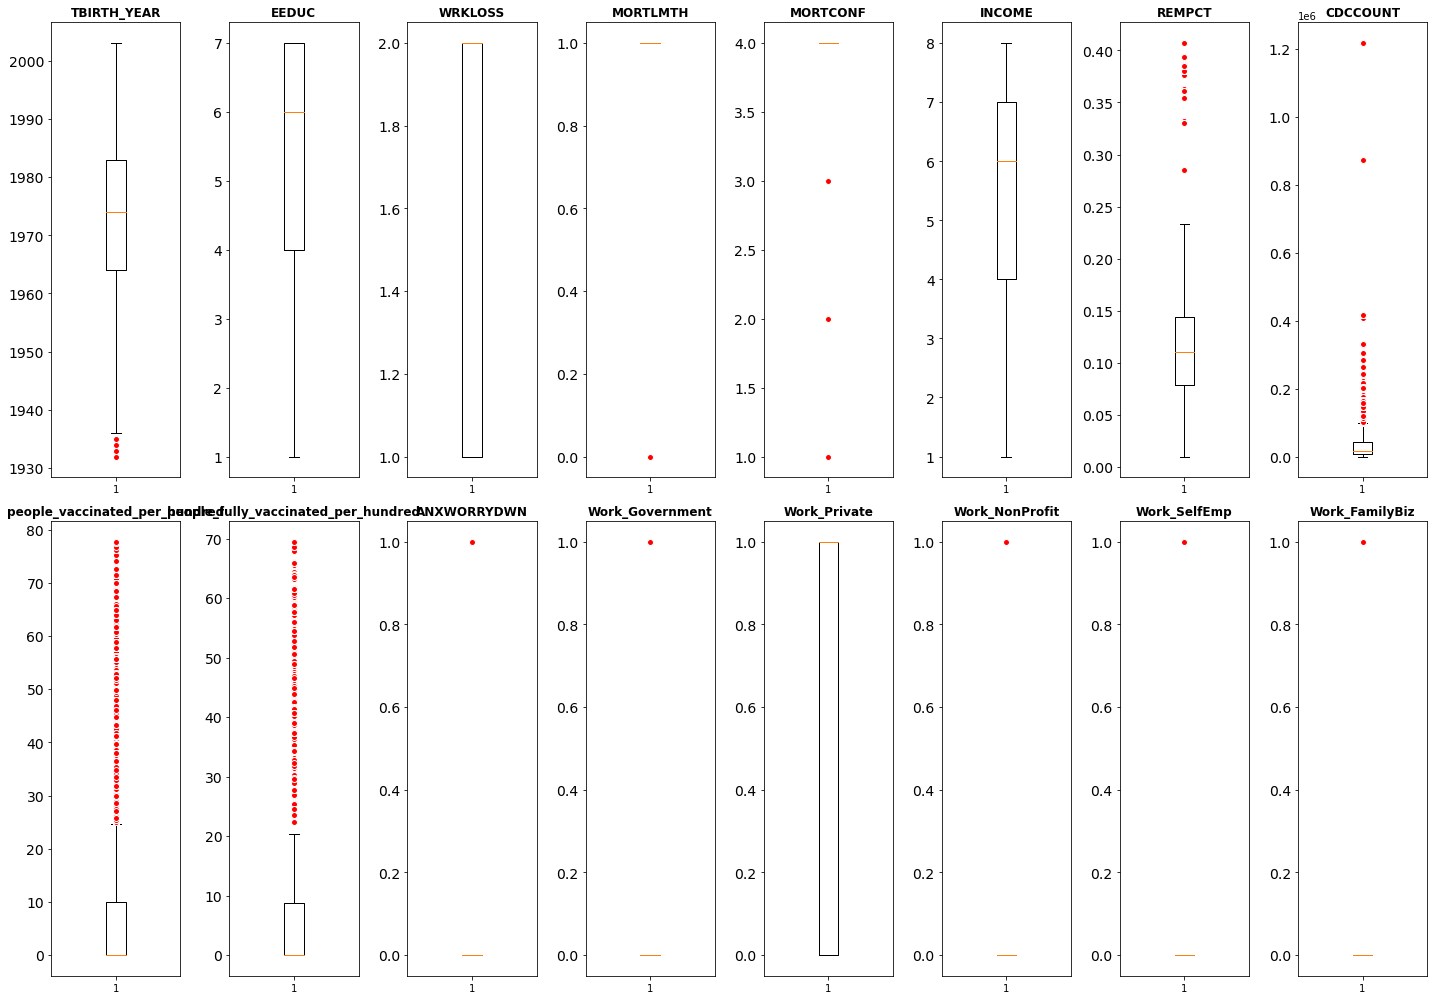

In [22]:
# box whisker plot  boxplot( seaborn and matplotlib)
# masterdf


#Creating subplot of each column with its own scale 
red_circle = dict(markerfacecolor='red' , marker='o', markeredgecolor='white') 
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))
                        
for i, ax in enumerate(axs.flat):
    ax.boxplot(masterdf.iloc[:,i], flierprops=red_circle) 
    ax.set_title(masterdf.columns[i], fontsize=12, fontweight='bold') 
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()




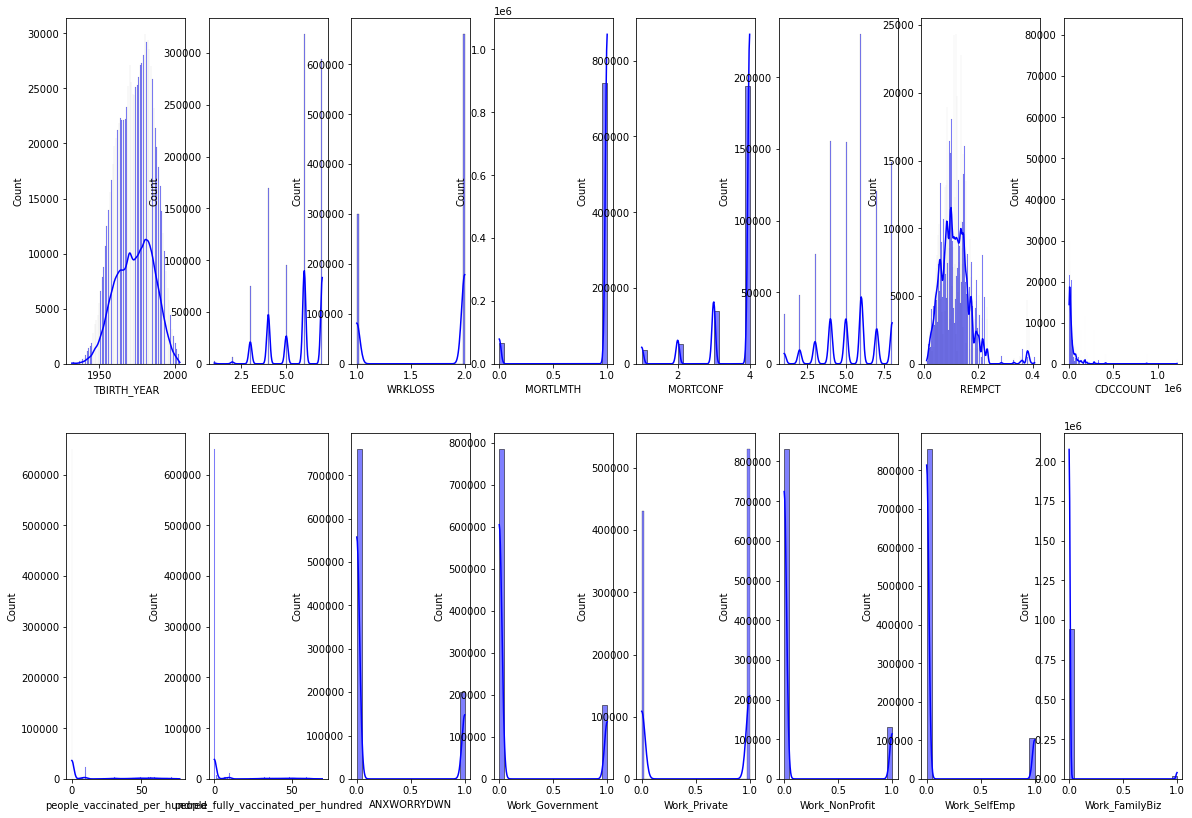

In [23]:
# distribution graph (kernel density estimate (kde) plot shape of dist)
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))

for i, ax in enumerate(axs.flat):
    #sns.distplot(df[l[i]],kde=True)
    #scores = df.loc[(df['prog'] == prog)]['score']

    # note how I put 'ax' here
    sns.histplot(masterdf.iloc[:,i], kde=True, ax=ax, color='b')

    """# change all the axes into ax
    sigma = round(scores.std(), 3)
    mu = round(scores.mean(), 2)
    ax.set_xlim(1,7)
    ax.set_xticks(range(2,8))
    ax.set_xlabel('Score - Mean: {} (σ {})'.format(mu, sigma))
    ax.set_ylabel('Density')
    """

plt.show()

4. **Performing modeling**

**split data into train test**

In [107]:
#cutoffdate=pd.to_datetime('2021-07-01')
#print(cutoffdate, mindate_w_vax)
#earlyda = mdf_mlm.loc[(mdf_mlm['YEARMONTH']<= cutoffdate) & (mdf_mlm['YEARMONTH']>=mindate_w_vax)]

X_train, X_test, y_train, y_test = train_test_split(
    masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['ANXWORRYDWN'])]], 
    masterdf['ANXWORRYDWN'], 
    test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(720541, 15)
(240181, 15)


* oversampling for RF model

In [108]:
print(y_train.value_counts())
y_train_awd1idx=y_train[y_train == 1].index
y_train_awd1=y_train[y_train_awd1idx]
y_train_rf=pd.concat([y_train, y_train_awd1, y_train_awd1],ignore_index=True)
print(y_train_rf.value_counts(), len(y_train_rf))

X_train_awd1=X_train.loc[y_train_awd1idx]
X_train_rf=pd.concat([X_train, X_train_awd1, X_train_awd1], ignore_index=True)
print(len(X_train_rf))

0    569760
1    150781
Name: ANXWORRYDWN, dtype: int64
0    569760
1    452343
Name: ANXWORRYDWN, dtype: int64 1022103
1022103


* Deploy xgboost model

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:28] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65617	validation_1-logloss:0.65631
[1]	validation_0-logloss:0.62622	validation_1-logloss:0.62636
[2]	validation_0-logloss:0.60137	validation_1-logloss:0.60171
[3]	validation_0-logloss:0.58086	validation_1-logloss:0.58133
[4]	validation_0-logloss:0.56382	validation_1-logloss:0.56436
[5]	validation_0-logloss:0.54956	validation_1-logloss:0.55019
[6]	validation_0-logloss:0.53766	validation_1-logloss:0.53832
[7]	validation_0-logloss:0.52760	validation_1-logloss:0.52838
[8]	validation_0-logloss:0.51918	validation_1-logloss:0.52001
[9]	validation_0-logloss:0.51208	validation_1-logloss:0.51300
[10]	validation_0-logloss:0.50609	validation_1-logloss:0.50710
[11]	validation_0-logloss:0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

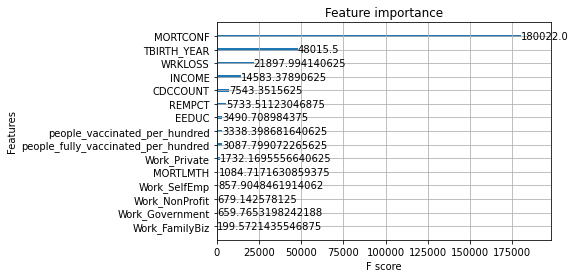

In [109]:
# Set up xg model, fit the model
mdf_xg =XGBClassifier(n_estimators=60,learning_rate=0.1) #optimize?
mdf_xg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], early_stopping_rounds=10, verbose=True)
print(mdf_xg.score(X_test, y_test))
#print(mdf_mlm_xg.evals_result())
feature_importance=mdf_xg.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
print(feature_imp_pd.sort_values(0, ascending=False))

#importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgg=mdf_xg.get_booster().get_score(importance_type='total_gain')
print(xgg)

xgb.plot_importance(mdf_xg,importance_type='total_gain') # jz

In [110]:
# run prediction and evaluate metrics
mdf_xg_p = mdf_xg.predict(X_test)
print(type(mdf_xg_p))

print('XG Accuracy score = ', metrics.accuracy_score(mdf_xg_p, y_test))
print('XG MAE = ', metrics.mean_absolute_error(mdf_xg_p, y_test))
print('XG RMSE = ', metrics.mean_squared_error(mdf_xg_p, y_test, squared=False))

<class 'numpy.ndarray'>
XG Accuracy score =  0.7922275284056607
XG MAE =  0.20777247159433926
XG RMSE =  0.455820657270312


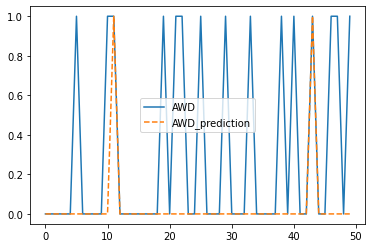

In [111]:
yt=pd.DataFrame(y_test.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdf_xg_p)
#print(ypredict[0:5])
plt.plot(yt[0:50], label = "AWD", linestyle="-")
plt.plot(ypredict[0:50], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()



* Deploying random forest model

In [112]:
# Set up RF model, fit the model
mdf_rf = RandomForestClassifier(n_estimators=200,min_samples_leaf=30,bootstrap=True, oob_score=True, n_jobs=-1)
mdf_rf.fit(X_train, y_train)

feature_importance=mdf_rf.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
#print(feature_imp_pd.sort_values(0, ascending=False))

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [113]:
feat_map= zip(X_train.columns, feature_imp_pd[0].to_list())
feat_map=pd.DataFrame(feat_map)
feat_map.columns=(['FEATURE','IMPORTANCE'])
print(feat_map.sort_values('IMPORTANCE', ascending=False))

print('score', mdf_rf.score(X_train,y_train))

                                FEATURE  IMPORTANCE
4                              MORTCONF    0.334689
0                           TBIRTH_YEAR    0.159791
7                              CDCCOUNT    0.094334
6                                REMPCT    0.086603
5                                INCOME    0.085641
2                               WRKLOSS    0.076116
3                              MORTLMTH    0.042082
8         people_vaccinated_per_hundred    0.033487
9   people_fully_vaccinated_per_hundred    0.032326
1                                 EEDUC    0.031806
11                         Work_Private    0.007271
10                      Work_Government    0.005314
13                         Work_SelfEmp    0.004881
12                       Work_NonProfit    0.004585
14                       Work_FamilyBiz    0.001074
score 0.7976575933916321


In [114]:
# run prediction and evaluate metrics
mdf_rf_p = mdf_rf.predict(X_test)
#print(type(mdf_rf_p))

print('RF Accuracy score= ', metrics.accuracy_score(mdf_rf_p, y_test))
print('RF MAE = ', metrics.mean_absolute_error(mdf_rf_p, y_test))
print('RF RMSE = ', metrics.mean_squared_error(mdf_rf_p, y_test, squared=False))
print('RF F1_score=', metrics.f1_score(mdf_rf_p, y_test))

RF Accuracy score=  0.7921817296122508
RF MAE =  0.20781827038774925
RF RMSE =  0.45587089223567373
RF F1_score= 0.08290155440414507


* Deploy NaiveBayes 

In [115]:
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)


0.7876268314312955

* Deploy MLPclassifier

In [116]:
clf = MLPClassifier(hidden_layer_sizes=(15,10,8,6,4), random_state=1, max_iter=200)
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test[:1]))
clf.score(X_test, y_test)

[[0.79130528 0.20869472]]


0.7903289602424838

In [117]:
mdf_mlp_p=clf.predict(X_test)
print('MLP Accuracy score= ', metrics.accuracy_score(mdf_mlp_p, y_test))
print('MLP MAE = ', metrics.mean_absolute_error(mdf_mlp_p, y_test))

MLP Accuracy score=  0.7903289602424838
MLP MAE =  0.20967103975751622


* Deploy logistic regression

In [118]:
clf = LogisticRegression(random_state=1, max_iter=200)
#clf = LogisticRegression(random_state=1, penalty='elasticnet', solver='saga',l1_ratio=0.7, max_iter=200)
clf.fit(X_train, y_train)

print(clf.predict_proba(X_test[:1]))
print(clf.score(X_test, y_test))

mdf_lr_p=clf.predict(X_test)
print('LR Accuracy score= ', metrics.accuracy_score(mdf_lr_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_lr_p, y_test))


[[0.83210161 0.16789839]]
0.7903289602424838
LR Accuracy score=  0.7903289602424838
LR MAE =  0.20967103975751622


**This is very interesting**

TBIRTH_YEAR 	 -0.0006313076660595344
EEDUC 	 -0.00024160786854805473
WRKLOSS 	 -0.0002007676808385554
MORTLMTH 	 -9.815274879914051e-05
MORTCONF 	 -0.000536150588428527
INCOME 	 -0.000850696539943484
REMPCT 	 2.8383780603182996e-06
CDCCOUNT 	 3.5945940608413846e-07
people_vaccinated_per_hundred 	 -0.004498009538856443
people_fully_vaccinated_per_hundred 	 -0.0036421817949964554
Work_Government 	 -7.213778207674463e-06
Work_Private 	 -8.146724066756332e-07
Work_NonProfit 	 6.258380978458151e-06
Work_SelfEmp 	 -4.6563024262833765e-06
Work_FamilyBiz 	 3.7128046872091367e-06


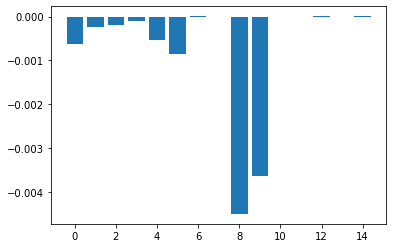

In [119]:
feat_imp = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(feat_imp):
    #print('%s, feature_score: %.5f' % (X_test.columns[i],v))
    print(X_test.columns[i],'\t',v)
# plot feature importance
plt.bar([x for x in range(len(feat_imp))], feat_imp)
plt.show()

* k nearest neighbors classifier

In [121]:
clf = KNeighborsClassifier(n_neighbors=100)
clf.fit(X_train, y_train)
mdf_knn_p=clf.predict(X_test)

In [122]:
#print(clf.score(X_test, y_test))
print('LR Accuracy score= ', metrics.accuracy_score(mdf_knn_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_knn_p, y_test))

LR Accuracy score=  0.7904080672492828
LR MAE =  0.20959193275071716


5. **Perform modeling at the aggregated state/YrMonth level**

* Evaluate multicollinearity

In [24]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = masterdfagg.loc[:, masterdfagg.columns[~masterdfagg.columns.isin(['ANXWORRYDWN','ANXWORRYDWN_NUM'])]]
calc_vif(X)

,variables,VIF
0,TBIRTH_YEAR,1.923665
1,EEDUC,4.969495
2,WRKLOSS,8.006996
3,MORTLMTH,5.222786
4,MORTCONF,7.130207
5,INCOME,5.739301
6,REMPCT,2.910503
7,CDCCOUNT,1.228315
8,people_vaccinated_per_hundred,35.721115
9,people_fully_vaccinated_per_hundred,40.956303


* Train and split the data

In [33]:
masterdfagg.head()
masterdfagg.shape

X_trainagg, X_testagg, y_trainagg, y_testagg = train_test_split(
    masterdfagg.loc[:, masterdfagg.columns[~masterdfagg.columns.isin(['ANXWORRYDWN','ANXWORRYDWN_NUM','Work_Private'])]], 
    masterdfagg['ANXWORRYDWN_NUM'], 
    test_size=0.25, random_state=42)

print(X_trainagg.shape)
print(X_testagg.shape)


(688, 14)
(230, 14)


In [34]:
print(masterdfagg['ANXWORRYDWN_NUM'].min(), masterdfagg['ANXWORRYDWN_NUM'].max())
print(masterdfagg['ANXWORRYDWN'].min(), masterdfagg['ANXWORRYDWN'].max())
masterdfagg.head()

4.4288256227758005 6.4871428571428575
0.0960591133004926 0.3352380952380952


TBIRTH_YEAR     EEDUC   WRKLOSS  MORTLMTH  MORTCONF  \
YEARMONTH  STATE_C                                                        
2020-04-01 AK       1977.778403  5.411699  1.674916  0.931384  3.622047   
           AL       1976.551980  5.242574  1.693069  0.878713  3.351485   
           AR       1975.945714  5.137143  1.705714  0.897143  3.428571   
           AZ       1974.171856  5.257783  1.689913  0.936488  3.554172   
           CA       1974.460798  5.660895  1.624339  0.938913  3.516595   

                      INCOME  REMPCT  CDCCOUNT  people_vaccinated_per_hundred  \
YEARMONTH  STATE_C                                                              
2020-04-01 AK       5.080990   0.130     147.0                            0.0   
           AL       4.495050   0.103   11431.0                            0.0   
           AR       4.345714   0.097    4713.0                            0.0   
           AZ       4.864259   0.159   16173.0                            0.0   
           CA       5.589707   0.154   70929.0                            0.0   

                    people_fully_vaccinated_per_hundred  ANXWORRYDWN_NUM  \
YEARMONTH  STATE_C                                                         
2020-04-01 AK                                       0.0         5.454443   
           AL                                       0.0         5.383663   
           AR                                       0.0         5.577143   
           AZ                                       0.0         5.489415   
           CA                                       0.0         5.722944   

                    ANXWORRYDWN  Work_Government  Work_Private  \
YEARMONTH  STATE_C                                               
2020-04-01 AK          0.200225         0.314961      0.425197   
           AL          0.193069         0.227723      0.549505   
           AR          0.214286         0.245714      0.531429   
           AZ          0.209215         0.176837      0.608966   
           CA          0.237614         0.182780      0.568543   

                    Work_NonProfit  Work_SelfEmp  Work_FamilyBiz  
YEARMONTH  STATE_C                                                
2020-04-01 AK             0.154106      0.085489        0.020247  
           AL             0.123762      0.089109        0.009901  
           AR             0.111429      0.088571        0.022857  
           AZ             0.088418      0.102117        0.023661  
           CA             0.116402      0.113516        0.018759

* XGBoost regressor

[0]	validation_0-rmse:4.45470	validation_1-rmse:4.46237
[1]	validation_0-rmse:4.01199	validation_1-rmse:4.01692
[2]	validation_0-rmse:3.61358	validation_1-rmse:3.61626
[3]	validation_0-rmse:3.25508	validation_1-rmse:3.25550
[4]	validation_0-rmse:2.93250	validation_1-rmse:2.93098
[5]	validation_0-rmse:2.64229	validation_1-rmse:2.63946
[6]	validation_0-rmse:2.38121	validation_1-rmse:2.37705
[7]	validation_0-rmse:2.14637	validation_1-rmse:2.14091
[8]	validation_0-rmse:1.93520	validation_1-rmse:1.92859
[9]	validation_0-rmse:1.74534	validation_1-rmse:1.73784
[10]	validation_0-rmse:1.57468	validation_1-rmse:1.56603
[11]	validation_0-rmse:1.42132	validation_1-rmse:1.41141
[12]	validation_0-rmse:1.28356	validation_1-rmse:1.27246
[13]	validation_0-rmse:1.15983	validation_1-rmse:1.14803
[14]	validation_0-rmse:1.04866	validation_1-rmse:1.03706
[15]	validation_0-rmse:0.94870	validation_1-rmse:0.93713
[16]	validation_0-rmse:0.85901	validation_1-rmse:0.84943
[17]	validation_0-rmse:0.77839	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

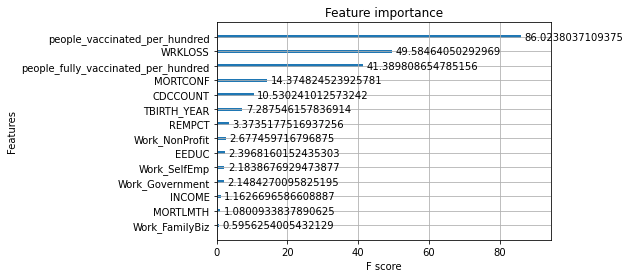

In [51]:
mdfagg_xg =XGBRegressor(n_estimators=30,learning_rate=0.1) #optimize?
mdfagg_xg.fit(X_trainagg, y_trainagg, eval_set=[(X_trainagg, y_trainagg),(X_testagg, y_testagg)], early_stopping_rounds=10, verbose=True)
print(mdfagg_xg.score(X_testagg, y_testagg))
#print(mdf_mlm_xg.evals_result())
feature_importance=mdfagg_xg.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
print(feature_imp_pd.sort_values(0, ascending=False))

#importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgg=mdfagg_xg.get_booster().get_score(importance_type='total_gain')
print(xgg)

xgb.plot_importance(mdfagg_xg,importance_type='total_gain') # jz


<class 'numpy.ndarray'>
XG MAE =  0.24281572276510385
XG RMSE =  0.08717630325256669
XG R2_score=  0.3080670653603731


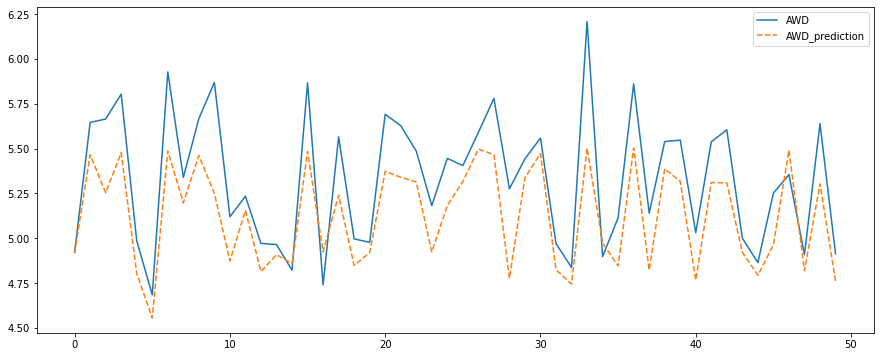

In [52]:
# run prediction and evaluate metrics
mdfagg_xg_p = mdfagg_xg.predict(X_testagg)
print(type(mdfagg_xg_p))

#print('XG Accuracy score = ', metrics.accuracy_score(mdfagg_xg_p, y_testagg))
print('XG MAE = ', metrics.mean_absolute_error(mdfagg_xg_p, y_testagg))
print('XG RMSE = ', metrics.mean_squared_error(mdfagg_xg_p, y_testagg, squared=True))
print('XG R2_score= ', metrics.r2_score(y_testagg,mdfagg_xg_p))

yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_xg_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:50], label = "AWD", linestyle="-")
plt.plot(ypredict[0:50], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()

* MLP Regressor model

In [47]:
clf = MLPRegressor(hidden_layer_sizes=(15,14,12,11,10,9,8,7,6,5,4,3),random_state=1, max_iter=20000)
clf.fit(X_trainagg, y_trainagg)
mdfagg_ml_p=clf.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('MLP MAE = ', metrics.mean_absolute_error(mdfagg_ml_p, y_testagg))
print('MLP RMSE = ', metrics.mean_squared_error(mdfagg_ml_p, y_testagg, squared=True))
print('MLP r2_score ', metrics.r2_score(y_testagg,mdfagg_ml_p))

MLP MAE =  0.32361851593262936
MLP RMSE =  0.21142370970448182
MLP r2_score  -0.6781054306052088


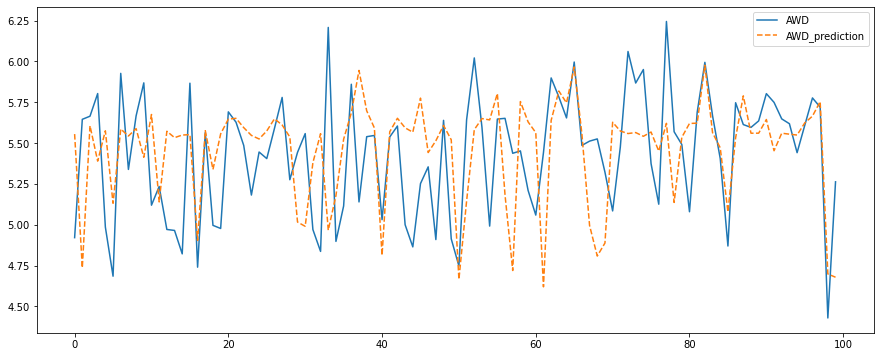

In [48]:
yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_ml_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:100], label = "AWD", linestyle="-")
plt.plot(ypredict[0:100], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()

* **regression models**

* linear regression

In [49]:
reg = linear_model.LinearRegression()
reg.fit(X_trainagg, y_trainagg)
reg.coef_
reg.score(X_testagg, y_testagg)
mdfagg_lr_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('LinReg MAE = ', metrics.mean_absolute_error(mdfagg_lr_p, y_testagg))
print('LinReg RMSE = ', metrics.mean_squared_error(mdfagg_lr_p, y_testagg, squared=True))
print('LinReg r2= ', metrics.r2_score(y_testagg,mdfagg_lr_p))


LinReg MAE =  0.1593707517301302
LinReg RMSE =  0.04199313984219613
LinReg r2=  0.666693408625497


Feature: TBIRTH_YEAR, 	 Score: 0.05127765
Feature: EEDUC, 	 Score: 0.30573176
Feature: WRKLOSS, 	 Score: -2.20786484
Feature: MORTLMTH, 	 Score: 2.25767862
Feature: MORTCONF, 	 Score: -1.30854743
Feature: INCOME, 	 Score: -0.04073208
Feature: REMPCT, 	 Score: 0.25828935
Feature: CDCCOUNT, 	 Score: 0.00000071
Feature: people_vaccinated_per_hundred, 	 Score: -0.00774139
Feature: people_fully_vaccinated_per_hundred, 	 Score: 0.01314968
Feature: Work_Government, 	 Score: 0.59532524
Feature: Work_NonProfit, 	 Score: -0.17417606
Feature: Work_SelfEmp, 	 Score: 1.44798103
Feature: Work_FamilyBiz, 	 Score: 1.24554982


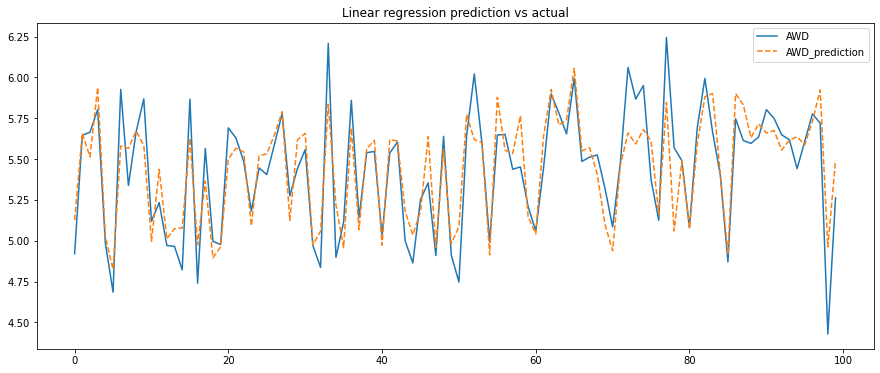

In [50]:
#print(reg.coef_)
for i,v in enumerate(reg.coef_):
    print('Feature: %s, \t Score: %.8f' % (X_trainagg.columns[i],v))

yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_lr_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:100], label = "AWD", linestyle="-")
plt.plot(ypredict[0:100], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.title("Linear regression prediction vs actual")
plt.show()

* Recursive feature elimination/ranking

In [59]:
from sklearn.feature_selection import RFE
estimator = linear_model.LinearRegression()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_trainagg, y_trainagg)
#print(selector.support_)
sel_rank=list(selector.ranking_)
for i in range(len(sel_rank)):
    print('feature:', X_trainagg.columns[i], '\t\t Ranking:', sel_rank[i])

feature: TBIRTH_YEAR 		 Ranking: 10
feature: EEDUC 		 Ranking: 8
feature: WRKLOSS 		 Ranking: 2
feature: MORTLMTH 		 Ranking: 1
feature: MORTCONF 		 Ranking: 3
feature: INCOME 		 Ranking: 11
feature: REMPCT 		 Ranking: 5
feature: CDCCOUNT 		 Ranking: 14
feature: people_vaccinated_per_hundred 		 Ranking: 13
feature: people_fully_vaccinated_per_hundred 		 Ranking: 12
feature: Work_Government 		 Ranking: 9
feature: Work_NonProfit 		 Ranking: 6
feature: Work_SelfEmp 		 Ranking: 4
feature: Work_FamilyBiz 		 Ranking: 7


* mutual information correlation

In [63]:
from sklearn.feature_selection import f_regression, mutual_info_regression

mi = mutual_info_regression(X_trainagg, y_trainagg)
print(mi)

for i in range(len(mi)):
    print('feature:', X_trainagg.columns[i], '\t\t MI score:', mi[i])

[0.         0.04573861 0.39628688 0.14091184 0.21337623 0.04978128
 0.02734368 0.08648659 0.41070204 0.42754493 0.         0.01804313
 0.         0.        ]
feature: TBIRTH_YEAR 		 MI score: 0.0
feature: EEDUC 		 MI score: 0.045738611461132006
feature: WRKLOSS 		 MI score: 0.39628687780397387
feature: MORTLMTH 		 MI score: 0.14091184348220676
feature: MORTCONF 		 MI score: 0.21337622835142023
feature: INCOME 		 MI score: 0.049781281343738826
feature: REMPCT 		 MI score: 0.027343675827292913
feature: CDCCOUNT 		 MI score: 0.08648659050566732
feature: people_vaccinated_per_hundred 		 MI score: 0.4107020382637834
feature: people_fully_vaccinated_per_hundred 		 MI score: 0.42754493145731365
feature: Work_Government 		 MI score: 0.0
feature: Work_NonProfit 		 MI score: 0.018043134275117723
feature: Work_SelfEmp 		 MI score: 0.0
feature: Work_FamilyBiz 		 MI score: 0.0


*  ridge regression

In [211]:
reg = linear_model.Ridge(alpha=0.15)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_ridge_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('ridge MAE = ', metrics.mean_absolute_error(mdfagg_ridge_p, y_testagg))
print('ridge RMSE = ', metrics.mean_squared_error(mdfagg_ridge_p, y_testagg, squared=True))
print('ridge r2= ', metrics.r2_score(y_testagg,mdfagg_ridge_p))

[ 4.71040902e-02  2.72555204e-01 -2.02721667e+00  6.51876243e-01
 -9.47318376e-01 -4.14752398e-02  1.73737306e-01  7.66104981e-07
 -8.75589873e-03  1.31667085e-02  9.79025783e-02 -4.74060223e-01
 -5.19054441e-01  7.62949209e-01  1.32262877e-01]
ridge MAE =  0.15970956963995725
ridge RMSE =  0.042431643170521297
ridge r2=  0.6632129341903947


* lasso reg   -- Result: performed poorly with average alpha, hence feature reduction is not feasible

In [212]:
reg = linear_model.Lasso(alpha=0.2)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_lasso_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('Lasso MAE = ', metrics.mean_absolute_error(mdfagg_lasso_p, y_testagg))
print('Lasso RMSE = ', metrics.mean_squared_error(mdfagg_lasso_p, y_testagg, squared=True))
print('Lasso r2= ', metrics.r2_score(y_testagg,mdfagg_lasso_p))

[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  9.41568723e-07
 -9.71791411e-03 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00]
Lasso MAE =  0.1912232791550981
Lasso RMSE =  0.061128831882974695
Lasso r2=  0.5148102126636833


* **lasso and lasso lars(AIC/BIC) cv**

Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


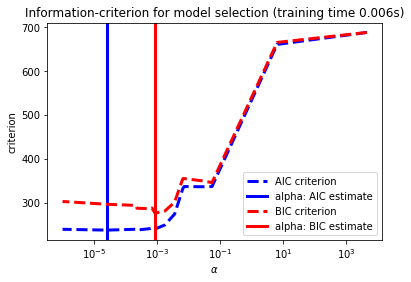

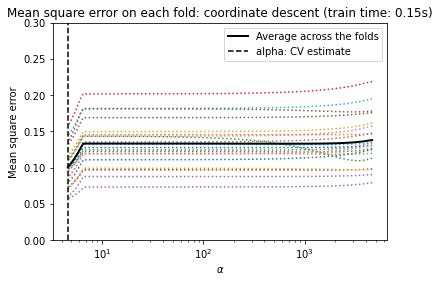

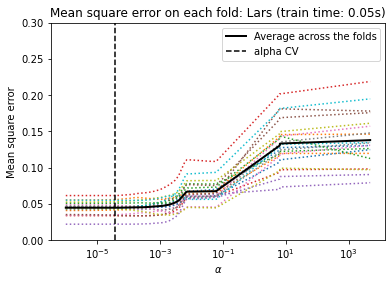

In [197]:
model_bic = linear_model.LassoLarsIC(criterion="bic", normalize=False)
t1 = time.time()
model_bic.fit(X_trainagg, y_trainagg)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = linear_model.LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X_trainagg, y_trainagg)
alpha_aic_ = model_aic.alpha_

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-6

def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)" % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = linear_model.LassoCV(cv=20).fit(X_trainagg, y_trainagg)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 0, 0.3
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold: coordinate descent (train time: %.2fs)"
    % t_lasso_cv
)
plt.axis("tight")
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = linear_model.LassoLarsCV(cv=20, normalize=False).fit(X_trainagg, y_trainagg)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_, ":")
plt.semilogx(
    model.cv_alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(model.alpha_, linestyle="--", color="k", label="alpha CV")
plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold: Lars (train time: %.2fs)" % t_lasso_lars_cv)
plt.axis("tight")
plt.ylim(ymin, ymax)

plt.show()

* elasticnet

In [210]:
reg = linear_model.ElasticNet(alpha=0.001,l1_ratio=0.1)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_lasso_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('ElasticNet MAE = ', metrics.mean_absolute_error(mdfagg_lasso_p, y_testagg))
print('ElasticNet RMSE = ', metrics.mean_squared_error(mdfagg_lasso_p, y_testagg, squared=True))
print('ElasticNet r2 = ', metrics.r2_score(y_testagg,mdfagg_lasso_p))

[ 3.83631896e-02  2.17331696e-01 -1.61638991e+00  0.00000000e+00
 -7.82663727e-01 -3.06925381e-02  8.74201134e-02  8.31793645e-07
 -9.60022136e-03  1.15578493e-02  1.29137102e-01 -3.32918568e-01
 -2.35237252e-01  3.93066909e-01  0.00000000e+00]
ElasticNet MAE =  0.16008355020043494
ElasticNet RMSE =  0.04290961490139757
ElasticNet r2 =  0.6594191924270874
